In [1]:
%load_ext autoreload
%autoreload 2
import networkx as nx

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"

import torch
import torch.nn as nn
from torch_geometric.data import Data, Batch
from torch_geometric.data import DataLoader
import argparse
import numpy as np
import random
import ogb
from ogb.graphproppred import PygGraphPropPredDataset, Evaluator
from graph_transformer import GT
from utils import pre_process, pre_process_with_summary, concat_pre_process_with_summary, inf_sum_pre_process_with_summary, fin_sum_pre_process_with_summary, get_n_params, get_optimizer
import datetime
from tqdm import tqdm
from tensorboardX import SummaryWriter
import torch.nn.functional as F
import pytz
from torch_geometric.utils import to_dense_adj, to_networkx, dense_to_sparse, remove_self_loops, to_undirected

In [2]:
parser = argparse.ArgumentParser(description='PyTorch implementation of relative positional encodings and relation-aware self-attention for graph Transformers')
args = parser.parse_args("")

args.dataset = 'ogbg-molhiv'
args.n_classes = 1
args.lr = 3e-4
args.n_hid = 512
args.n_heads = 8
args.n_layer = 4
args.dropout = 0.3
args.num_epochs = 50
# args.num_epochs = 1
args.k_hop_neighbors = 3
args.k_hop = True
args.weight_decay = 1e-2
# args.bsz      = 512
args.bsz      = 448
args.strategies = ['ea', 'rw_concat']
args.summary_node = True
args.hier_levels = 3
args.lap_k = None
args.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
args.metric = 'rocauc'
print("device:", args.device)

device: cuda


In [3]:
print("Loading data...")
print("dataset: {} ".format(args.dataset))
tz = pytz.timezone('US/Pacific')
time_now = datetime.datetime.now(tz).strftime('%m-%d_%H:%M:%S')

if args.summary_node:
    pre_transform = lambda d : concat_pre_process_with_summary(d, args)
    root_path= f'dataset/{args.dataset}/concat_with_summary_{args.k_hop_neighbors}'
    # args.writer = SummaryWriter(log_dir=f'runs_new/{args.dataset}/concat_with_summary_{args.k_hop_neighbors}/strats={"-".join(args.strategies)}/{time_now}')

else:
    pre_transform = lambda d : pre_process(d, args)
    root_path= f'dataset/{args.dataset}/{args.k_hop_neighbors}'
    # args.writer = SummaryWriter(log_dir=f'runs_new/{args.dataset}/k={args.k_hop_neighbors}/strats={"-".join(args.strategies)}/{time_now}')
    
    
dataset = PygGraphPropPredDataset(name=args.dataset, pre_transform=pre_transform, root = root_path)
orig_dataset = PygGraphPropPredDataset(name=args.dataset)
evaluator = Evaluator(name=args.dataset)
split_idx = dataset.get_idx_split()
edge_dim_dict = {'ea': None, \
                 'disc': {
#                      'sd': (dataset.data.sd_edge_attr.max(dim=0)[0].int().view(-1) + 1).tolist(), \
#                      'cn': (dataset.data.cn_edge_attr.max(dim=0)[0].int().view(-1) + 1).tolist(), \
#                      'hsd': (dataset.data.hsd_edge_attr.max(dim=0)[0].int().view(-1) + 1).tolist(), \
                    },
                 'cont': {
                     **{('rw_' + str(k)): args.n_hid for k in range(1, args.k_hop_neighbors + 1)}
#                      'rw': args.n_hid
                 }
                }
model = GT(args.n_hid, args.n_classes, args.n_heads, args.n_layer, edge_dim_dict, args.dropout, args.summary_node, args.lap_k).to(args.device)

Loading data...
dataset: ogbg-molhiv 


In [4]:
valid_loader = DataLoader(dataset[split_idx["valid"]], batch_size=args.bsz, shuffle = False)
test_loader  = DataLoader(dataset[split_idx["test"]],  batch_size=args.bsz, shuffle = False)

orig_valid_loader = DataLoader(orig_dataset[split_idx["valid"]], batch_size=args.bsz, shuffle = False)
orig_test_loader  = DataLoader(orig_dataset[split_idx["test"]],  batch_size=args.bsz, shuffle = False)

In [5]:
print('Model #Params: %d' % get_n_params(model))

criterion = torch.nn.BCEWithLogitsLoss(reduction = "sum")

optimizer = get_optimizer(model, weight_decay = args.weight_decay, learning_rate = args.lr)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 500, eta_min=1e-6)
scheduler.step(-500)

Model #Params: 10338819


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://git

In [6]:
import seaborn as sb
def mat_visualize(node_size, edge_index, edge_attr):
    mat = np.zeros((node_size, node_size))
    for e, v in zip(edge_index, edge_attr):
        mat[e[0]][e[1]] = v
    sb.heatmap(mat)

/opt/conda/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [7]:
def turn_prob(inp):
    prob = torch.sigmoid(inp)
    prob = torch.cat([prob, 1-prob], dim=1)
    return prob

In [8]:
train_mask = torch.zeros(len(dataset), dtype=bool)
valid_mask = torch.zeros(len(dataset), dtype=bool)
test_mask = torch.zeros(len(dataset), dtype=bool)

train_mask[split_idx["train"]] = True
valid_mask[split_idx["valid"]] = True
test_mask[split_idx["test"]] = True
def entropy_loss(pred, label):
    return torch.mean(torch.sum(-label * pred, dim=1))

In [9]:
stats = []
for epoch in range(args.num_epochs):
    model.train()
    train_loss = []
    train_adv  = []
    y_true = []
    y_scores = []
    all_idx = torch.randperm(len(dataset))
    for batch_idx in tqdm(range(len(all_idx) // args.bsz)):
        batch = all_idx[batch_idx * args.bsz : (batch_idx + 1) * args.bsz]
        train_msk = train_mask[batch]    
        data = Batch.from_data_list(dataset[batch])
        data.to(args.device)
        
        strats = {'ea': data.edge_attr, \
                  **{('rw_' + str(k)): data['rw_edge_attr_' + str(k)] for k in range(1, args.k_hop_neighbors + 1)}}
#         strats = {'ea': data.edge_attr, 'rw': data.rw_edge_attr}
        out, reps = model(data.x, data.batch, data.edge_index, strats)
        with torch.no_grad():
            strats = {'ea': data.edge_attr, \
                  **{('rw_' + str(k)): data['rw_edge_attr_' + str(k)] for k in range(1, args.k_hop_neighbors + 1)}}
            # strats = {'ea': data.edge_attr, 'rw': data.rw_edge_attr}
            adv_out, reps = model(data.x, data.batch, data.edge_index, strats)
        
        # loss = criterion(out[train_msk], data.y[train_msk].float())
        loss = 0.0
        numel = 0
        for idx, orig_data in enumerate(orig_dataset[batch]):
            if not train_msk[idx]:
                continue
            orig_adj = to_dense_adj(edge_index=to_undirected(orig_data.edge_index), max_num_nodes=orig_data.x.size(0))[0].float().to(args.device)
            normalized = F.normalize(reps[data.batch == idx][:-1])
            pred_adj = model.temp(torch.mm(normalized, normalized.t()).unsqueeze(-1)).squeeze(-1)
            loss += criterion(pred_adj, orig_adj + torch.eye(orig_adj.size(0), device=orig_adj.device))
            numel += pred_adj.numel()
        loss = loss / numel
        
        adv_loss = entropy_loss(turn_prob(out[train_msk]).log(), turn_prob(adv_out[train_msk]))
        adv_loss = adv_loss * 0
        (loss + 0.5 * adv_loss).backward()
        optimizer.step()
        optimizer.zero_grad()
        scheduler.step()
        
        train_loss += [loss.item()]
        train_adv  += [adv_loss.item()]
        
        y_true += [data.y]
        y_scores += [out]

    input_dict = {"y_true": torch.cat(y_true), "y_pred": torch.cat(y_scores)}
    train_metric = evaluator.eval(input_dict)[args.metric]
    

    model.eval()
    with torch.no_grad():
        valid_loss = []
        y_true = []
        y_scores = []
        for num_iters, (data, orig_data_batch) in enumerate(tqdm(zip(valid_loader, orig_valid_loader))):
            data.to(args.device)
            strats = {'ea': data.edge_attr, \
                  **{('rw_' + str(k)): data['rw_edge_attr_' + str(k)] for k in range(1, args.k_hop_neighbors + 1)}}
            # strats = {'ea': data.edge_attr, 'rw': data.rw_edge_attr}
            out, reps = model(data.x, data.batch, data.edge_index, strats)
        
            # loss = criterion(out, data.y.float())
            loss = 0.0
            numel = 0
            for idx, orig_data in enumerate(orig_data_batch.to_data_list()):
                orig_adj = to_dense_adj(edge_index=to_undirected(orig_data.edge_index), max_num_nodes=orig_data.x.size(0))[0].float().to(args.device)
                normalized = F.normalize(reps[data.batch == idx][:-1])
                pred_adj = model.temp(torch.mm(normalized, normalized.t()).unsqueeze(-1)).squeeze(-1)
                loss += criterion(pred_adj, orig_adj + torch.eye(orig_adj.size(0), device=orig_adj.device))
                numel += pred_adj.numel()
            loss = loss / numel
            
            valid_loss += [loss.item()]

            y_true += [data.y]
            y_scores += [out]

        input_dict = {"y_true": torch.cat(y_true), "y_pred": torch.cat(y_scores)}
        valid_metric = evaluator.eval(input_dict)[args.metric]
        
        test_loss = []
        y_true = []
        y_scores = []
        for (data, orig_data_batch) in zip(test_loader, orig_test_loader):
            data.to(args.device)
            strats = {'ea': data.edge_attr, \
                  **{('rw_' + str(k)): data['rw_edge_attr_' + str(k)] for k in range(1, args.k_hop_neighbors + 1)}}
            # strats = {'ea': data.edge_attr, 'rw': data.rw_edge_attr}
            out, reps = model(data.x, data.batch, data.edge_index, strats)
        
            # loss = criterion(out, data.y.float())
            loss = 0.0
            numel = 0
            for idx, orig_data in enumerate(orig_data_batch.to_data_list()):
                orig_adj = to_dense_adj(edge_index=to_undirected(orig_data.edge_index), max_num_nodes=orig_data.x.size(0))[0].float().to(args.device)
                normalized = F.normalize(reps[data.batch == idx][:-1])
                pred_adj = model.temp(torch.mm(normalized, normalized.t()).unsqueeze(-1)).squeeze(-1)
                loss += criterion(pred_adj, orig_adj + torch.eye(orig_adj.size(0), device=orig_adj.device))
                numel += pred_adj.numel()
            loss = loss / numel
        
            test_loss += [loss.item()]

            y_true += [data.y]
            y_scores += [out]

        input_dict = {"y_true": torch.cat(y_true), "y_pred": torch.cat(y_scores)}
        test_metric = evaluator.eval(input_dict)[args.metric]

    print('Epoch %d: LR: %.5f, Train loss: %.3f Train %s: %.3f Train Adv: %.3f Valid loss: %.3f  Valid %s: %.3f \
        Test loss: %.3f  Test %s: %.3f' \
          % (epoch + 1, optimizer.param_groups[0]['lr'], np.average(train_loss), args.metric, train_metric, \
             np.average(train_adv), np.average(valid_loss), args.metric, valid_metric, \
             np.average(test_loss), args.metric, test_metric))
    stats += [[epoch, np.average(train_loss), train_metric, np.average(valid_loss), valid_metric, np.average(test_loss), test_metric]]

100%|██████████| 91/91 [02:54<00:00,  1.92s/it]
10it [00:13,  1.38s/it]
  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 1: LR: 0.00002, Train loss: 0.548 Train rocauc: 0.481 Train Adv: 0.000 Valid loss: 0.552  Valid rocauc: 0.406         Test loss: 0.554  Test rocauc: 0.388


100%|██████████| 91/91 [02:55<00:00,  1.93s/it]
10it [00:13,  1.39s/it]
  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 2: LR: 0.00009, Train loss: 0.547 Train rocauc: 0.499 Train Adv: 0.000 Valid loss: 0.549  Valid rocauc: 0.406         Test loss: 0.552  Test rocauc: 0.388


100%|██████████| 91/91 [02:54<00:00,  1.91s/it]
10it [00:11,  1.18s/it]
  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 3: LR: 0.00017, Train loss: 0.544 Train rocauc: 0.499 Train Adv: 0.000 Valid loss: 0.543  Valid rocauc: 0.406         Test loss: 0.546  Test rocauc: 0.388


100%|██████████| 91/91 [02:45<00:00,  1.82s/it]
10it [00:11,  1.15s/it]
  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 4: LR: 0.00025, Train loss: 0.538 Train rocauc: 0.507 Train Adv: 0.000 Valid loss: 0.534  Valid rocauc: 0.406         Test loss: 0.536  Test rocauc: 0.388


100%|██████████| 91/91 [02:55<00:00,  1.93s/it]
10it [00:11,  1.18s/it]
  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 5: LR: 0.00029, Train loss: 0.529 Train rocauc: 0.495 Train Adv: 0.000 Valid loss: 0.522  Valid rocauc: 0.406         Test loss: 0.525  Test rocauc: 0.388


100%|██████████| 91/91 [02:54<00:00,  1.91s/it]
10it [00:11,  1.17s/it]
  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 6: LR: 0.00029, Train loss: 0.520 Train rocauc: 0.507 Train Adv: 0.000 Valid loss: 0.510  Valid rocauc: 0.406         Test loss: 0.513  Test rocauc: 0.388


100%|██████████| 91/91 [02:53<00:00,  1.91s/it]
10it [00:11,  1.18s/it]
  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 7: LR: 0.00025, Train loss: 0.511 Train rocauc: 0.490 Train Adv: 0.000 Valid loss: 0.499  Valid rocauc: 0.406         Test loss: 0.503  Test rocauc: 0.388


100%|██████████| 91/91 [02:52<00:00,  1.90s/it]
10it [00:11,  1.16s/it]
  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 8: LR: 0.00017, Train loss: 0.504 Train rocauc: 0.488 Train Adv: 0.000 Valid loss: 0.491  Valid rocauc: 0.406         Test loss: 0.495  Test rocauc: 0.388


100%|██████████| 91/91 [02:53<00:00,  1.90s/it]
10it [00:12,  1.25s/it]
  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 9: LR: 0.00009, Train loss: 0.499 Train rocauc: 0.514 Train Adv: 0.000 Valid loss: 0.487  Valid rocauc: 0.406         Test loss: 0.490  Test rocauc: 0.388


100%|██████████| 91/91 [02:52<00:00,  1.90s/it]
10it [00:11,  1.17s/it]
  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 10: LR: 0.00002, Train loss: 0.496 Train rocauc: 0.477 Train Adv: 0.000 Valid loss: 0.485  Valid rocauc: 0.406         Test loss: 0.489  Test rocauc: 0.388


100%|██████████| 91/91 [02:56<00:00,  1.94s/it]
10it [00:12,  1.24s/it]
  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 11: LR: 0.00000, Train loss: 0.496 Train rocauc: 0.504 Train Adv: 0.000 Valid loss: 0.484  Valid rocauc: 0.406         Test loss: 0.488  Test rocauc: 0.388


100%|██████████| 91/91 [02:54<00:00,  1.91s/it]
10it [00:11,  1.17s/it]
  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 12: LR: 0.00003, Train loss: 0.496 Train rocauc: 0.500 Train Adv: 0.000 Valid loss: 0.484  Valid rocauc: 0.406         Test loss: 0.488  Test rocauc: 0.388


100%|██████████| 91/91 [02:56<00:00,  1.93s/it]
10it [00:11,  1.18s/it]
  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 13: LR: 0.00009, Train loss: 0.495 Train rocauc: 0.490 Train Adv: 0.000 Valid loss: 0.482  Valid rocauc: 0.406         Test loss: 0.486  Test rocauc: 0.388


100%|██████████| 91/91 [02:53<00:00,  1.91s/it]
10it [00:12,  1.25s/it]
  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 14: LR: 0.00017, Train loss: 0.492 Train rocauc: 0.494 Train Adv: 0.000 Valid loss: 0.477  Valid rocauc: 0.406         Test loss: 0.482  Test rocauc: 0.388


100%|██████████| 91/91 [02:46<00:00,  1.83s/it]
10it [00:11,  1.11s/it]
  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 15: LR: 0.00025, Train loss: 0.488 Train rocauc: 0.484 Train Adv: 0.000 Valid loss: 0.470  Valid rocauc: 0.406         Test loss: 0.475  Test rocauc: 0.388


100%|██████████| 91/91 [02:52<00:00,  1.89s/it]
10it [00:11,  1.16s/it]
  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 16: LR: 0.00029, Train loss: 0.481 Train rocauc: 0.487 Train Adv: 0.000 Valid loss: 0.461  Valid rocauc: 0.406         Test loss: 0.466  Test rocauc: 0.388


100%|██████████| 91/91 [02:52<00:00,  1.89s/it]
10it [00:11,  1.16s/it]
  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 17: LR: 0.00029, Train loss: 0.474 Train rocauc: 0.498 Train Adv: 0.000 Valid loss: 0.452  Valid rocauc: 0.406         Test loss: 0.457  Test rocauc: 0.388


100%|██████████| 91/91 [02:53<00:00,  1.91s/it]
10it [00:11,  1.15s/it]
  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 18: LR: 0.00025, Train loss: 0.467 Train rocauc: 0.501 Train Adv: 0.000 Valid loss: 0.444  Valid rocauc: 0.406         Test loss: 0.450  Test rocauc: 0.388


100%|██████████| 91/91 [02:53<00:00,  1.90s/it]
10it [00:11,  1.16s/it]
  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 19: LR: 0.00017, Train loss: 0.461 Train rocauc: 0.497 Train Adv: 0.000 Valid loss: 0.439  Valid rocauc: 0.406         Test loss: 0.444  Test rocauc: 0.388


100%|██████████| 91/91 [02:55<00:00,  1.92s/it]
10it [00:11,  1.15s/it]
  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 20: LR: 0.00009, Train loss: 0.458 Train rocauc: 0.481 Train Adv: 0.000 Valid loss: 0.435  Valid rocauc: 0.406         Test loss: 0.441  Test rocauc: 0.388


100%|██████████| 91/91 [02:51<00:00,  1.88s/it]
10it [00:11,  1.17s/it]
  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 21: LR: 0.00002, Train loss: 0.456 Train rocauc: 0.492 Train Adv: 0.000 Valid loss: 0.434  Valid rocauc: 0.406         Test loss: 0.440  Test rocauc: 0.388


100%|██████████| 91/91 [02:50<00:00,  1.88s/it]
10it [00:10,  1.07s/it]
  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 22: LR: 0.00000, Train loss: 0.455 Train rocauc: 0.504 Train Adv: 0.000 Valid loss: 0.434  Valid rocauc: 0.406         Test loss: 0.439  Test rocauc: 0.388


100%|██████████| 91/91 [02:53<00:00,  1.90s/it]
10it [00:11,  1.19s/it]
  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 23: LR: 0.00003, Train loss: 0.455 Train rocauc: 0.494 Train Adv: 0.000 Valid loss: 0.434  Valid rocauc: 0.406         Test loss: 0.439  Test rocauc: 0.388


100%|██████████| 91/91 [02:54<00:00,  1.91s/it]
10it [00:11,  1.18s/it]
  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 24: LR: 0.00009, Train loss: 0.454 Train rocauc: 0.499 Train Adv: 0.000 Valid loss: 0.432  Valid rocauc: 0.406         Test loss: 0.438  Test rocauc: 0.388


100%|██████████| 91/91 [02:56<00:00,  1.93s/it]
10it [00:11,  1.19s/it]
  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 25: LR: 0.00017, Train loss: 0.452 Train rocauc: 0.502 Train Adv: 0.000 Valid loss: 0.429  Valid rocauc: 0.406         Test loss: 0.434  Test rocauc: 0.388


100%|██████████| 91/91 [02:48<00:00,  1.85s/it]
10it [00:10,  1.06s/it]
  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 26: LR: 0.00025, Train loss: 0.449 Train rocauc: 0.510 Train Adv: 0.000 Valid loss: 0.423  Valid rocauc: 0.406         Test loss: 0.429  Test rocauc: 0.388


100%|██████████| 91/91 [02:51<00:00,  1.89s/it]
10it [00:11,  1.16s/it]
  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 27: LR: 0.00029, Train loss: 0.444 Train rocauc: 0.514 Train Adv: 0.000 Valid loss: 0.417  Valid rocauc: 0.406         Test loss: 0.423  Test rocauc: 0.388


100%|██████████| 91/91 [02:54<00:00,  1.92s/it]
10it [00:11,  1.17s/it]
  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 28: LR: 0.00029, Train loss: 0.438 Train rocauc: 0.497 Train Adv: 0.000 Valid loss: 0.410  Valid rocauc: 0.406         Test loss: 0.417  Test rocauc: 0.388


100%|██████████| 91/91 [02:53<00:00,  1.91s/it]
10it [00:11,  1.17s/it]
  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 29: LR: 0.00025, Train loss: 0.433 Train rocauc: 0.500 Train Adv: 0.000 Valid loss: 0.405  Valid rocauc: 0.406         Test loss: 0.411  Test rocauc: 0.388


100%|██████████| 91/91 [02:55<00:00,  1.93s/it]
10it [00:11,  1.17s/it]
  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 30: LR: 0.00017, Train loss: 0.429 Train rocauc: 0.487 Train Adv: 0.000 Valid loss: 0.400  Valid rocauc: 0.406         Test loss: 0.407  Test rocauc: 0.388


100%|██████████| 91/91 [02:55<00:00,  1.93s/it]
10it [00:11,  1.15s/it]
  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 31: LR: 0.00009, Train loss: 0.426 Train rocauc: 0.485 Train Adv: 0.000 Valid loss: 0.398  Valid rocauc: 0.406         Test loss: 0.405  Test rocauc: 0.388


100%|██████████| 91/91 [02:52<00:00,  1.90s/it]
10it [00:11,  1.15s/it]
  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 32: LR: 0.00002, Train loss: 0.424 Train rocauc: 0.497 Train Adv: 0.000 Valid loss: 0.397  Valid rocauc: 0.406         Test loss: 0.404  Test rocauc: 0.388


100%|██████████| 91/91 [02:56<00:00,  1.94s/it]
10it [00:11,  1.14s/it]
  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 33: LR: 0.00000, Train loss: 0.424 Train rocauc: 0.494 Train Adv: 0.000 Valid loss: 0.397  Valid rocauc: 0.406         Test loss: 0.404  Test rocauc: 0.388


100%|██████████| 91/91 [02:53<00:00,  1.91s/it]
10it [00:11,  1.16s/it]
  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 34: LR: 0.00003, Train loss: 0.424 Train rocauc: 0.502 Train Adv: 0.000 Valid loss: 0.397  Valid rocauc: 0.406         Test loss: 0.404  Test rocauc: 0.388


100%|██████████| 91/91 [02:51<00:00,  1.89s/it]
10it [00:11,  1.15s/it]
  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 35: LR: 0.00009, Train loss: 0.423 Train rocauc: 0.495 Train Adv: 0.000 Valid loss: 0.396  Valid rocauc: 0.406         Test loss: 0.403  Test rocauc: 0.388


100%|██████████| 91/91 [02:53<00:00,  1.90s/it]
10it [00:12,  1.21s/it]
  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 36: LR: 0.00017, Train loss: 0.422 Train rocauc: 0.501 Train Adv: 0.000 Valid loss: 0.393  Valid rocauc: 0.406         Test loss: 0.400  Test rocauc: 0.388


100%|██████████| 91/91 [02:50<00:00,  1.87s/it]
10it [00:10,  1.01s/it]
  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 37: LR: 0.00025, Train loss: 0.419 Train rocauc: 0.504 Train Adv: 0.000 Valid loss: 0.389  Valid rocauc: 0.406         Test loss: 0.397  Test rocauc: 0.388


100%|██████████| 91/91 [02:52<00:00,  1.90s/it]
10it [00:11,  1.19s/it]
  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 38: LR: 0.00029, Train loss: 0.415 Train rocauc: 0.496 Train Adv: 0.000 Valid loss: 0.385  Valid rocauc: 0.406         Test loss: 0.392  Test rocauc: 0.387


100%|██████████| 91/91 [02:53<00:00,  1.91s/it]
10it [00:11,  1.15s/it]
  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 39: LR: 0.00029, Train loss: 0.411 Train rocauc: 0.485 Train Adv: 0.000 Valid loss: 0.380  Valid rocauc: 0.406         Test loss: 0.388  Test rocauc: 0.387


100%|██████████| 91/91 [02:56<00:00,  1.94s/it]
10it [00:12,  1.24s/it]
  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 40: LR: 0.00025, Train loss: 0.407 Train rocauc: 0.502 Train Adv: 0.000 Valid loss: 0.376  Valid rocauc: 0.406         Test loss: 0.384  Test rocauc: 0.387


100%|██████████| 91/91 [02:57<00:00,  1.95s/it]
10it [00:12,  1.30s/it]
  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 41: LR: 0.00017, Train loss: 0.404 Train rocauc: 0.508 Train Adv: 0.000 Valid loss: 0.373  Valid rocauc: 0.406         Test loss: 0.381  Test rocauc: 0.387


100%|██████████| 91/91 [02:52<00:00,  1.90s/it]
10it [00:11,  1.17s/it]
  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 42: LR: 0.00009, Train loss: 0.402 Train rocauc: 0.497 Train Adv: 0.000 Valid loss: 0.371  Valid rocauc: 0.406         Test loss: 0.379  Test rocauc: 0.387


100%|██████████| 91/91 [02:51<00:00,  1.89s/it]
10it [00:11,  1.15s/it]
  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 43: LR: 0.00002, Train loss: 0.401 Train rocauc: 0.496 Train Adv: 0.000 Valid loss: 0.371  Valid rocauc: 0.406         Test loss: 0.379  Test rocauc: 0.387


100%|██████████| 91/91 [02:52<00:00,  1.89s/it]
10it [00:11,  1.14s/it]
  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 44: LR: 0.00000, Train loss: 0.401 Train rocauc: 0.508 Train Adv: 0.000 Valid loss: 0.370  Valid rocauc: 0.406         Test loss: 0.379  Test rocauc: 0.387


100%|██████████| 91/91 [02:52<00:00,  1.90s/it]
10it [00:11,  1.16s/it]
  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 45: LR: 0.00003, Train loss: 0.401 Train rocauc: 0.501 Train Adv: 0.000 Valid loss: 0.370  Valid rocauc: 0.406         Test loss: 0.379  Test rocauc: 0.387


100%|██████████| 91/91 [02:49<00:00,  1.87s/it]
10it [00:11,  1.10s/it]
  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 46: LR: 0.00009, Train loss: 0.400 Train rocauc: 0.507 Train Adv: 0.000 Valid loss: 0.370  Valid rocauc: 0.406         Test loss: 0.378  Test rocauc: 0.387


100%|██████████| 91/91 [02:45<00:00,  1.82s/it]
10it [00:11,  1.14s/it]
  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 47: LR: 0.00018, Train loss: 0.399 Train rocauc: 0.497 Train Adv: 0.000 Valid loss: 0.368  Valid rocauc: 0.406         Test loss: 0.376  Test rocauc: 0.387


100%|██████████| 91/91 [02:52<00:00,  1.89s/it]
10it [00:11,  1.12s/it]
  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 48: LR: 0.00025, Train loss: 0.397 Train rocauc: 0.503 Train Adv: 0.000 Valid loss: 0.365  Valid rocauc: 0.406         Test loss: 0.374  Test rocauc: 0.387


100%|██████████| 91/91 [02:45<00:00,  1.82s/it]
10it [00:11,  1.15s/it]
  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 49: LR: 0.00030, Train loss: 0.394 Train rocauc: 0.497 Train Adv: 0.000 Valid loss: 0.362  Valid rocauc: 0.406         Test loss: 0.371  Test rocauc: 0.387


100%|██████████| 91/91 [02:55<00:00,  1.93s/it]
10it [00:13,  1.32s/it]


Epoch 50: LR: 0.00029, Train loss: 0.391 Train rocauc: 0.491 Train Adv: 0.000 Valid loss: 0.359  Valid rocauc: 0.406         Test loss: 0.368  Test rocauc: 0.387


In [10]:
print(model.temp.weight)

Parameter containing:
tensor([[-0.4999]], device='cuda:0', requires_grad=True)


[5.         0.5198916  0.50699594 0.50956821 0.40593768 0.51290465
 0.38766971]


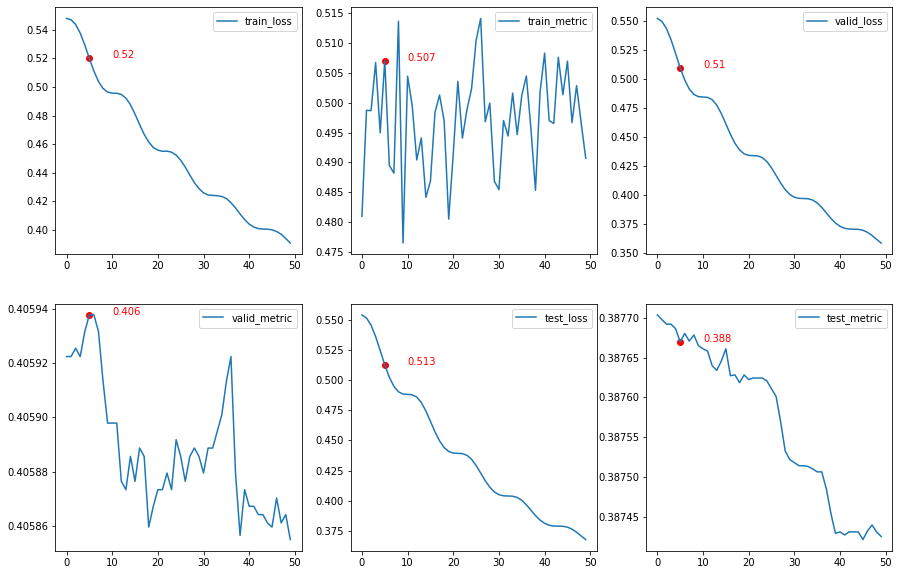

In [11]:
import matplotlib.pyplot as plt
labels = ['epoch', 'train_loss', 'train_metric', 'valid_loss', 'valid_metric', 'test_loss', 'test_metric']
fig = plt.figure(figsize=(15, 10))
stats_np = np.array(stats)
best_valid = stats_np[stats_np[:50, 4].argmax()]
print(best_valid)
for i in range(1, stats_np.shape[-1]):
    ax = fig.add_subplot(2, 3, i)
    ax.plot(stats_np[:, i], label=labels[i])
    ax.scatter(x=best_valid[0], y=best_valid[i], color='red')
    ax.annotate(best_valid[i].round(3), xy=(best_valid[0]+5, best_valid[i]), color='red')
    ax.legend()


In [12]:
import random
from torch_geometric.utils import degree
from torch.distributions.multinomial import Multinomial

def generateSequence(startIndex, transitionMatrix, path_length, alpha):
    result = [startIndex]
    current = startIndex

    for i in range(0, path_length):
        if random.random() < alpha:
            nextIndex = startIndex
        else:
            probs = transitionMatrix[current]
            assert np.sum(probs) != 0, print(probs)
            nextIndex = np.random.choice(len(probs), 1, p=probs)[0]

        result.append(nextIndex)
        current = nextIndex

    return result

def weighted_random_walk(data, transitionMatrix, path_length, alpha, degree_weighted_start=True, num_samples=3):
    if degree_weighted_start:
        # Exclude degree 1 nodes, soft max over remaining degrees
        p = degree(data.edge_index[0])
        p[p == 1] = 0
    else:
        p = torch.ones(data.num_nodes)    
    m = Multinomial(num_samples, probs=p.exp()-1)
    start_node = m.sample().long().tolist()
    start = torch.Tensor(sum([[i] * start_node[i] for i in range(len(start_node))], [])).long()
    
    sentenceList = []
    nodes = list(range(data.num_nodes))
    
    for j in range(0, num_samples):
        indexList = generateSequence(start[j].item(), transitionMatrix, path_length, alpha)
        sentence = [nodes[tmp] for tmp in indexList]
        sentence = torch.LongTensor(sentence).unique()
        sentenceList.append(sentence)

    return sentenceList

In [13]:
from draw_mols_demo import pyg_to_mol, mol_to_svg, HorizontalDisplay
from torch_geometric.utils import sort_edge_index

model.eval()
# threshold = 0.1

for idx in range(20, 41):
    orig_data = orig_dataset[idx]

    data = dataset[idx]
    data.to(args.device)
    strats = {'ea': data.edge_attr,  **{('rw_' + str(k)): data['rw_edge_attr_' + str(k)] for k in range(1, args.k_hop_neighbors + 1)}}
    out, _ = model(data.x, 0, data.edge_index, strats)
    
    imgs = []
    for layer_idx, gc in enumerate(model.gcs):

        adj = to_dense_adj(edge_index=data.edge_index, edge_attr=gc.att)[0]
        adj_mean = adj.mean(dim=-1).detach().cpu()
        adj_mean = adj_mean[:-1, :-1] # remove virtual node
        
        # only include edges that were in the original graph
#         orig_adj = to_dense_adj(edge_index=orig_data.edge_index)[0].bool()
#         adj_mean[~orig_adj] = 0
        adj_mean /= adj_mean.sum(dim=1, keepdim=True)
        
#         adj_mean_sorted = adj_mean.flatten().sort()[0]
#         adj_mean_sorted = adj_mean_sorted[adj_mean_sorted != 0]
#         adj_mean_threshold = adj_mean_sorted[int(threshold * len(adj_mean_sorted))]
#         adj_mean[adj_mean < adj_mean_threshold] = 0
#         adj_mean[adj_mean >= adj_mean_threshold] = 1
        subsetList = weighted_random_walk(orig_data, adj_mean.cpu().numpy(), 10, 0)
        edgeIndexList = []
        for s in subsetList:
            edgeIndexList.append(torch.LongTensor(s).repeat_interleave(2)[1:-1].reshape(-1, 2))
        mean_edge_index = sort_edge_index(torch.cat(edgeIndexList).t().contiguous())[0]
    
        # mean_edge_index = dense_to_sparse(adj_mean.long())[0]
        mean_data = Data(x=data.x, edge_index=mean_edge_index)

        mol = pyg_to_mol(mean_data)  
        svg = mol_to_svg(mol, molSize=(150, 150))
        imgs += [svg]

    mol = pyg_to_mol(orig_data)
    svg = mol_to_svg(mol, molSize=(150, 150))
    imgs += [svg]
    row = HorizontalDisplay(*imgs)
    display(row)

In [14]:
from draw_mols_demo import pyg_to_mol, mol_to_svg, HorizontalDisplay

model.eval()
# threshold = 0.0
orig_dataset = PygGraphPropPredDataset(name='ogbg-molhiv')

for idx in range(20, 41):
    orig_data = orig_dataset[idx]

    data = dataset[idx]
    data.to(args.device)
    strats = {'ea': data.edge_attr,  **{('rw_' + str(k)): data['rw_edge_attr_' + str(k)] for k in range(1, args.k_hop_neighbors + 1)}}
    out, reps = model(data.x, 0, data.edge_index, strats)
    
    imgs = []
    normalized = F.normalize(reps[:-1])
    adj_mean = model.temp(torch.mm(normalized, normalized.t()))
    adj_mean = adj_mean.sigmoid()
    adj_mean[adj_mean >= 0.5] = 1
    adj_mean[adj_mean < 0.5] = 0
    adj_mean -= torch.eye(adj_mean.size(0), device=adj_mean.device)

    mean_edge_index = dense_to_sparse(adj_mean.long())[0]
    mean_data = Data(x=data.x, edge_index=mean_edge_index)

    mol = pyg_to_mol(mean_data)  
    svg = mol_to_svg(mol, molSize=(150, 150))
    imgs += [svg]

    mol = pyg_to_mol(orig_data)
    svg = mol_to_svg(mol, molSize=(150, 150))
    imgs += [svg]
    row = HorizontalDisplay(*imgs)
    display(row)

RuntimeError: mat1 dim 1 must match mat2 dim 0